# Wholesale Customers

Description:
* 440 rows, 2 parent and 6 child features

Parent features:
* Channel, Region

Child features:
* Fresh, Milk, Grocery, Frozen, Detergents_Paper, Delicassen

Source: https://www.kaggle.com/binovi/wholesale-customers-data-set

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
ws = pd.read_csv("../data/wholesale.csv")

In [10]:
parent = ws[['Channel', 'Region']]
parent.head()

,Channel,Region
0,2,3
1,2,3
2,2,3
3,1,3
4,2,3


In [11]:
child = ws[['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']]
child.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [12]:
import tensorflow as tf
import sys
sys.path.append("C:/Users/notes/grab")

X = parent.values.astype(np.float32)
y = child.values.astype(np.float32)
dataset = tf.data.Dataset \
    .from_tensor_slices((X, y)) \
    .shuffle(X.size).batch(40)

In [23]:
from model.gmm import GMM
# Build GMM
gmm = GMM(x_features=X.shape[1],
          y_features=y.shape[1],
          n_components=100,
          n_hidden=50)
gmm.fit(dataset, epochs=1000, plot=True, verbose=True, logdir='gmm/wholesale')

0 [NLL: 139101904.0]
100 [NLL: 80273.3671875]
200 [NLL: 31403.107421875]
300 [NLL: 3228.516357421875]
400 [NLL: 7269.2734375]
500 [NLL: 3094.723876953125]
600 [NLL: 1522.510009765625]
700 [NLL: 649.7222900390625]
800 [NLL: 344.7168884277344]
900 [NLL: 143.3804168701172]


<tf.Tensor: shape=(), dtype=float32, numpy=135.76678>

In [24]:
%load_ext tensorboard
%tensorboard --logdir logs/gmm_wholesale --host localhost

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 11432), started 2:46:00 ago. (Use '!kill 11432' to kill it.)

In [25]:
y_hat = gmm.sample(X)

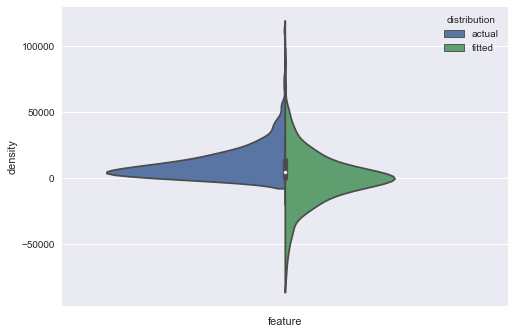

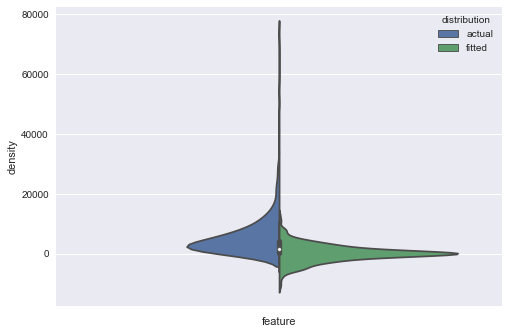

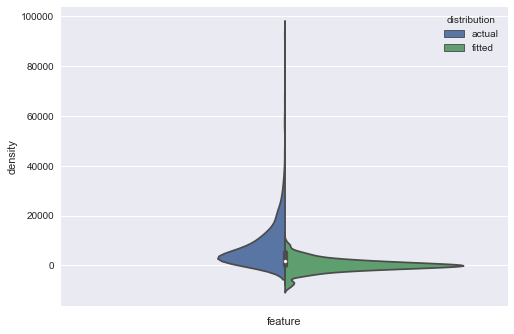

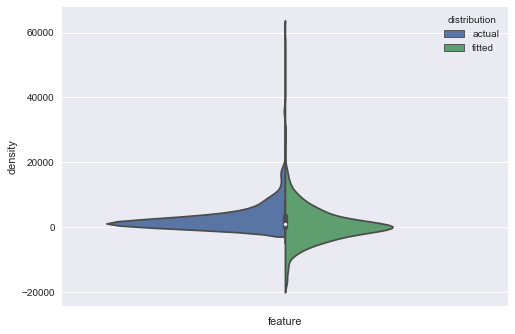

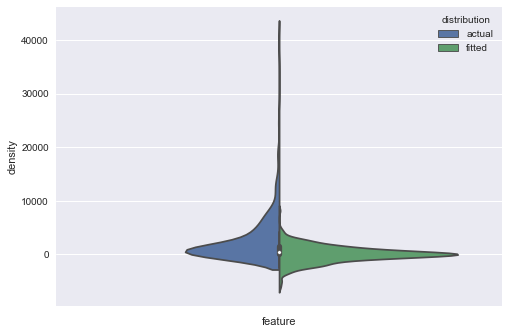

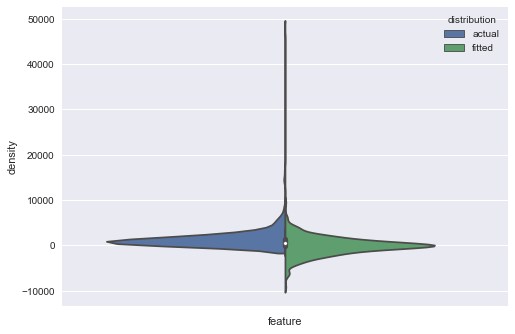

In [26]:
from visualisation.visualisation import Visualisation

gmm_viz = Visualisation(gmm, X, y)
for i in range(y.shape[1]):
    gmm_viz.plot_violin(y[:,i], y_hat[:,i])

In [32]:
import numpy as np


def prob_overlap(y, y_hat, bins=10):
    """Get probabilities of each bin, ignoring zeroes."""
    p, b = np.histogram(y, bins)
    q, _ = np.histogram(y_hat, b)
    p, q = p / y.shape[0], q / y.shape[0]
    idx = np.intersect1d(np.nonzero(p), np.nonzero(q))
    return p[idx], q[idx]

def kl(p, q):
    """Compute KL divergence."""
    return np.sum(p * np.log(p / q))

def js(p, q):
    """Compute JS divergence."""
    m = 0.5 * (p + q)
    return 0.5 * (kl(p, m) + kl(q, m))

In [33]:
np.histogram(y, 10)

(array([2269,  259,   66,   26,    9,    5,    4,    0,    1,    1],
       dtype=int64),
 array([3.000000e+00, 1.121780e+04, 2.243260e+04, 3.364740e+04,
        4.486220e+04, 5.607700e+04, 6.729180e+04, 7.850660e+04,
        8.972140e+04, 1.009362e+05, 1.121510e+05], dtype=float32))

In [27]:
# from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_hat, bins=10)
print("KL:", kl(p, q))
print("JS:", js(p, q))

KL: 4.091138169473218
JS: 0.2546335438418871


In [28]:
from model.cgan import CGAN

cgan = CGAN(x_features=X.shape[1],
            y_features=y.shape[1],
            latent_dim=32)

cgan.fit(dataset, epochs=1000, verbose=True)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 16)           528         input_8[0][0]                    
__________________________________________________________________________________________________
dense_21 (Dense)                (None, 16)           48          input_9[0][0]                    
____________________________________________________________________________________________

In [29]:
y_hat = cgan.sample(X)

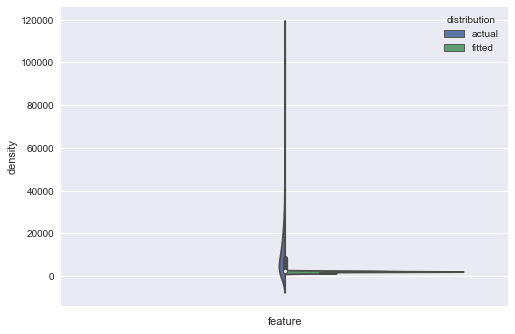

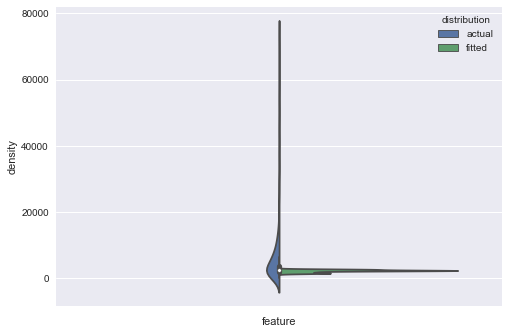

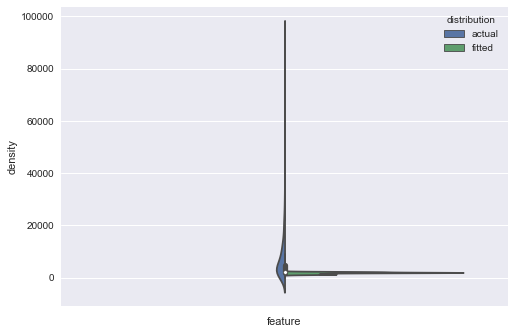

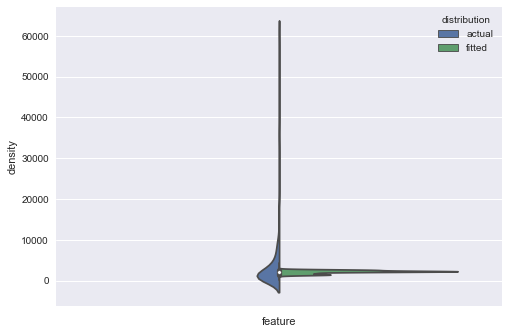

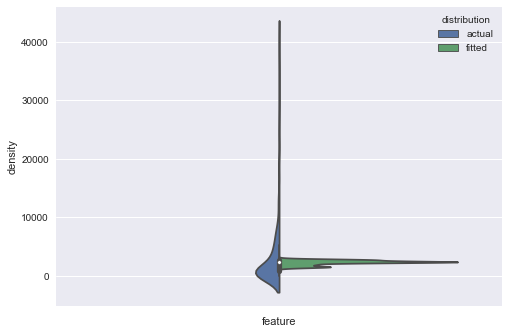

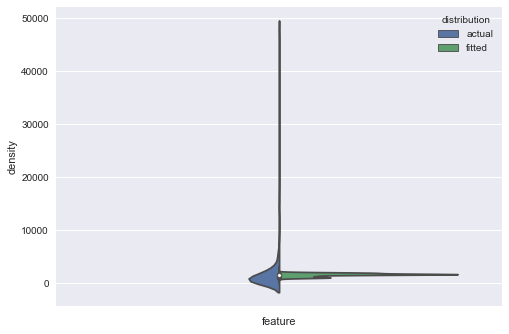

In [30]:
cgan_viz = Visualisation(cgan, X, y)
for i in range(y.shape[1]):
    cgan_viz.plot_violin(y[:,i], y_hat[:,i])

In [31]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_hat, bins=10)
print("KL:", kl(p, q))
print("JS:", js(p, q))

KL: -0.7809470569932275
JS: 0.015946166424782415
